# Mean Flow

In [99]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [100]:
class MeanFlow(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super(MeanFlow, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    # predict velocity field at time t for input x_t
    def forward(self, x_t: Tensor, r: Tensor, t: Tensor) -> Tensor:
        # concatenate time with input: (B, 1) and (B, D) -> (B, D+1)
        return self.net(torch.cat([r, t, x_t], dim=-1))
    

def sampler_r_t(n_samples: int, p: float) -> Tensor:
    # sample r and t such that 0 <= r < t <= 1
    # sample a pair (x1, x2), uniformly distributed in [0, 1]
    # assign the larger value to t and the smaller value to r
    # set a certain portion p of random smaples with r == t
    x1, x2 = torch.rand(n_samples, 2).T
    r, t = torch.min(x1, x2), torch.max(x1, x2)
    
    # set a portion p of samples with r == t
    n_equal = int(n_samples * p)
    if n_equal > 0:
        indices = torch.randperm(n_samples)[:n_equal]
        r[indices] = t[indices]
        
    return r.view(-1, 1), t.view(-1, 1)

In [101]:
# mean flow loss function
def loss_fcn(predict, target, p=0.5):
    l2 = nn.MSELoss()(target, predict)

    w = 1./(l2 + 1e-3)**p  # avoid division by zero

    return l2 * w.detach()

In [102]:
# training 
meanflow = MeanFlow(input_dim=2, hidden_dim=64)
optimizer = torch.optim.Adam(meanflow.parameters(), lr=1e-4)

epochs = 300000
for epoch in range(epochs):
    
    # generate data
    x = Tensor(make_moons(n_samples=512, noise=0.05)[0])
    
    # sample r and t
    r, t = sampler_r_t(x.shape[0], p=0.75)  # 75% of samples with r == t
    
    # introduce noise
    e = torch.randn_like(x) 

    # interpolate
    z = (1 - t) * x + t * e
    v = e - x

    u, dudt = torch.func.jvp(meanflow, (z, r, t), (v, torch.zeros_like(r), torch.ones_like(t)))

    # target velocity field at time t
    u_tgt = v - (t - r) * dudt
    
    # backpropagation
    optimizer.zero_grad()
    loss = loss_fcn(u, u_tgt.detach()) # stop gradient for u_tgt
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    loss.backward()
    optimizer.step() 

    # save checkpoint
    if epoch % 10000 == 0:
        torch.save(meanflow.state_dict(), f'meanflow_epoch_{epoch}.pt')
        print(f'Saved checkpoint at epoch {epoch}')
    


Epoch 0, Loss: 1.2620744705200195
Saved checkpoint at epoch 0
Epoch 100, Loss: 1.164389729499817
Epoch 200, Loss: 1.0747480392456055
Epoch 300, Loss: 0.9845892786979675
Epoch 400, Loss: 0.985551655292511
Epoch 500, Loss: 0.9558118581771851
Epoch 600, Loss: 0.9563957452774048
Epoch 700, Loss: 0.9880403876304626
Epoch 800, Loss: 0.9697632789611816
Epoch 900, Loss: 0.9131138324737549
Epoch 1000, Loss: 1.0007777214050293
Epoch 1100, Loss: 0.9457280039787292
Epoch 1200, Loss: 0.992885410785675
Epoch 1300, Loss: 0.9642688035964966
Epoch 1400, Loss: 0.9473732709884644
Epoch 1500, Loss: 0.9748405814170837
Epoch 1600, Loss: 0.9545206427574158
Epoch 1700, Loss: 0.9267715215682983
Epoch 1800, Loss: 0.9722607731819153
Epoch 1900, Loss: 0.9527940154075623
Epoch 2000, Loss: 0.9519584774971008
Epoch 2100, Loss: 0.9531275033950806
Epoch 2200, Loss: 0.9960545301437378
Epoch 2300, Loss: 0.9746495485305786
Epoch 2400, Loss: 0.9512069821357727
Epoch 2500, Loss: 0.9522932171821594
Epoch 2600, Loss: 0.95765

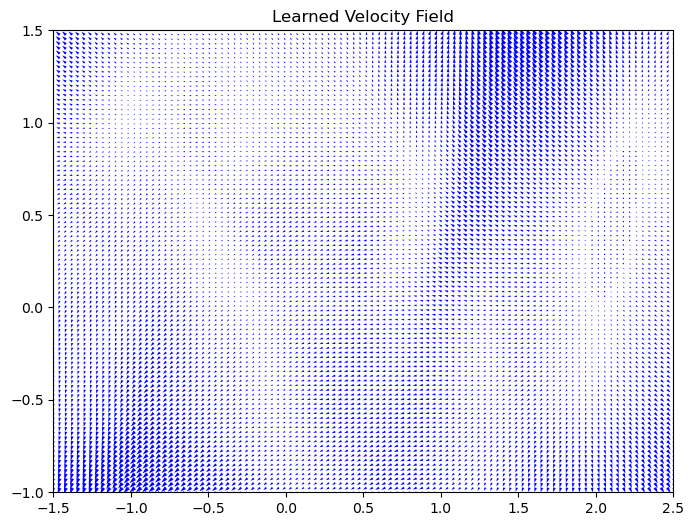

In [103]:
# visualize the learned velocity field
with torch.no_grad():
    x_grid = torch.linspace(-1.5, 2.5, 100)
    y_grid = torch.linspace(-1, 1.5, 100)
    X, Y = torch.meshgrid(x_grid, y_grid)
    grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1)

    r = torch.zeros(grid_points.shape[0], 1)  # r = 0 for visualization
    t = torch.ones(grid_points.shape[0], 1)   # t = 1 for visualization

    velocity_field = meanflow(grid_points, r, t).numpy()

    plt.figure(figsize=(8, 6))
    plt.quiver(X.numpy(), Y.numpy(), velocity_field[:, 0].reshape(X.shape), velocity_field[:, 1].reshape(Y.shape), color='blue')
    plt.title('Learned Velocity Field')
    plt.xlim(-1.5, 2.5)
    plt.ylim(-1, 1.5)
    plt.show()

In [104]:
# Sampling after training
num_points = 512
e = torch.randn(num_points, 2)  # initial points'
xg = e - meanflow(x_t = e, r = torch.zeros(num_points, 1), t = torch.ones(num_points, 1))


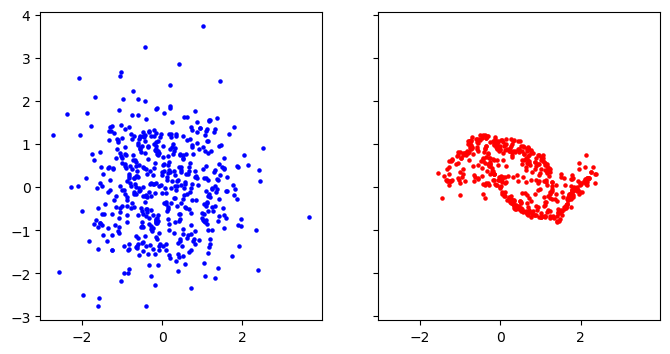

In [105]:
# plot the results with final checkpoints
fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
axes[0].scatter(e[:, 0].detach().numpy(), e[:, 1].detach().numpy(), s=5, c='blue', label='initial points')
axes[1].scatter(xg[:, 0].detach().numpy(), xg[:, 1].detach().numpy(), s=5, c='red', label='generated points')


C:\Users\yf3831\AppData\Local\Temp\ipykernel_97040\820853958.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meanflow.load_state_dict(torch.load(f'meanflow_epoch_{ckpt}.

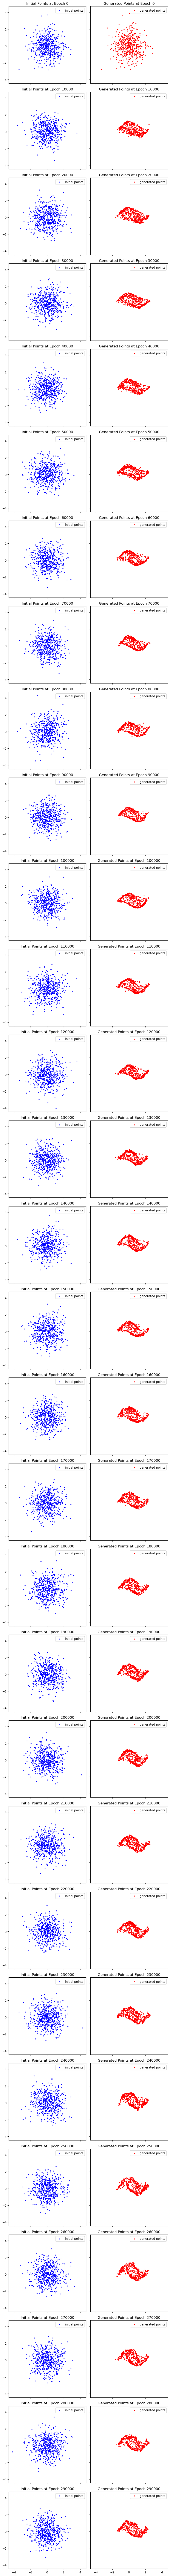

In [106]:
# plot with different checkpoints
ckpts = list(range(0, epochs, 10000))
fig, axes = plt.subplots(len(ckpts), 2, figsize=(8,4*len(ckpts)), sharex=True, sharey=True)

for i, ckpt in enumerate(ckpts):
    meanflow.load_state_dict(torch.load(f'meanflow_epoch_{ckpt}.pt'))
    
    # generate new points
    e = torch.randn(num_points, 2)
    xg = e - meanflow(x_t = e, r = torch.zeros(num_points, 1), t = torch.ones(num_points, 1))
    
    axes[i, 0].scatter(e[:, 0].detach().numpy(), e[:, 1].detach().numpy(), s=5, c='blue', label='initial points')
    axes[i, 1].scatter(xg[:, 0].detach().numpy(), xg[:, 1].detach().numpy(), s=5, c='red', label='generated points')
    axes[i, 0].set_title(f'Initial Points at Epoch {ckpt}')
    axes[i, 1].set_title(f'Generated Points at Epoch {ckpt}')
    axes[i, 0].legend()
    axes[i, 1].legend()
    plt.tight_layout()

plt.show()

